In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from functools import partial
import scipy as sp
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm


### Sources

https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

https://michael-fuchs-python.netlify.app/2019/11/15/multinomial-logistic-regression/

Kamils notebook

In [2]:
# Load Data
files = ["../Data/model_data/model-encoded-data-0.csv", 
         "../Data/model_data/model-encoded-data-1.csv", 
         "../Data/model_data/model-encoded-data-2.csv"]
model_dfs = [pd.read_csv(f, sep=",", 
                          encoding='Latin-1', 
                          low_memory=False ) for f in files]

# combine the list of dataframes
df = pd.concat(model_dfs, ignore_index=True)

In [3]:
#For now don't use these columns as they are not processed yet
cols_excl =  ['country', 'year'] #['occupation', 'proficient_languages', 'desktop_OS', 'country', 'year', 'IT_experience_in_years']
df = df.drop(cols_excl, axis=1)

In [4]:
#df_salary is a dataframe after dropping data points with NaN in 'compensation'
df_salary = df.dropna(subset=['compensation'])[df.dropna(subset=['compensation'])['compensation']!=0]
print('Dataframe without NaN and 0 in compensation is {}%'.format(round(len(df_salary)/len(df)*100, 2)), 'of the original dataframe.')
print('There are {}'.format(len(df_salary)), 'data points in it compared to {}'.format(len(df)), 'entries in the original dataframe.\n')
print('Information on missing values in the dataframe df_salary:')
df_salary.isna().sum()/len(df_salary)*100

Dataframe without NaN and 0 in compensation is 100.0% of the original dataframe.
There are 252740 data points in it compared to 252740 entries in the original dataframe.

Information on missing values in the dataframe df_salary:


is_female                   0.0
is_male                     0.0
is_gender_non_confirming    0.0
is_transgender              0.0
is_gender_unknown           0.0
                           ... 
is_IT_expr_above_11         0.0
is_IT_expr_below_2          0.0
compensation                0.0
job_satisfaction            0.0
GDP                         0.0
Length: 61, dtype: float64

In [5]:
# Not used in this model
comp_int_dict = {'below-20000': 1, '20000-40000': 2, '40000-60000': 3, '60000_to_80000': 4, '60000-80000': 4, 
                 '80000-100000': 5,'100000-120000': 6, '12000-140000': 7, '120000-140000':7,
                 '140000-160000': 8, 'above-160000': 9}

In [6]:
# Need string labels for logistic multinomial regression, investigate labels
df_salary['compensation'].value_counts()

below-20000       59338
40000-60000       39073
20000-40000       37019
above-160000      25499
80000-100000      23519
60000-to-80000    23242
100000-120000     16868
120000-140000     10701
60000-80000        9603
140000-160000      7878
Name: compensation, dtype: int64

In [7]:
# Replace 60000-to-80000 with 60000-80000
comp_str_dict = {'60000-to-80000': '60000-80000'}

df_salary.replace({'compensation':comp_str_dict}, inplace=True)

df_salary['compensation'].value_counts()

below-20000      59338
40000-60000      39073
20000-40000      37019
60000-80000      32845
above-160000     25499
80000-100000     23519
100000-120000    16868
120000-140000    10701
140000-160000     7878
Name: compensation, dtype: int64

In [8]:

# SKLearn logistic multinomial regression does not work on numerical response
#df_salary.replace({'compensation':comp_int_dict}, inplace=True)

In [9]:
#Define data (predictors) and response
data_df = df_salary.copy()

# Some code to scale numerical data
cols_to_scale = ['job_satisfaction', 'GDP']
train_numerical = data_df[cols_to_scale].copy()
sc = StandardScaler()
sc.fit(train_numerical)
train_scaled = sc.transform(train_numerical)
train_scaled = pd.DataFrame(train_scaled, columns = train_numerical.columns)
data_df_scaled = pd.concat([data_df.drop(cols_to_scale, axis=1), train_scaled], axis=1)
display(data_df_scaled.head()) #scaled job satisfaction and GDP data
 
print(data_df_scaled.columns) #checking that 'compensation' is not there
# data = data_df_scaled.to_numpy()

# Keep salary as respons without changing it into numeric
salary = df_salary['compensation']


data = data_df_scaled.drop('compensation', axis=1)
data = data.drop('GDP', axis=1).to_numpy()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_occupation_other,is_occupation_system_admin,is_occupation_web_developer,is_IT_expr_2_to_5,is_IT_expr_6_to_10,is_IT_expr_above_11,is_IT_expr_below_2,compensation,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,above-160000,1.33255,1.119652
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,above-160000,1.33255,1.119652
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,above-160000,1.33255,1.119652
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,above-160000,1.33255,1.119652
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,above-160000,1.33255,1.119652


Index(['is_female', 'is_male', 'is_gender_non_confirming', 'is_transgender',
       'is_gender_unknown', 'is_age_18_to_24', 'is_age_25_to34',
       'is_age_35_44', 'is_age_45_54', 'is_age_55_to_64', 'is_age_above_65',
       'is_age_below_18', 'is_company_size_1000_to_4999',
       'is_company_size_100_to_499', 'is_company_size_5000_to_9999',
       'is_company_size_500_to_999', 'is_company_size_unknown',
       'is_company_size_above_10000', 'is_company_size_below_100',
       'is_desktop_os_linux', 'is_desktop_os_mac', 'is_desktop_os_unix',
       'is_desktop_os_windows', 'is_lang_c#', 'is_lang_c_c++',
       'is_lang_hadoop', 'is_lang_html_css', 'is_lang_java',
       'is_lang_javascript_nodejs', 'is_lang_lua', 'is_lang_objective_C',
       'is_lang_other', 'is_lang_perl', 'is_lang_php', 'is_lang_powershell',
       'is_lang_python', 'is_lang_r', 'is_lang_ruby', 'is_lang_scala',
       'is_lang_sql', 'is_lang_swift', 'is_lang_visual_basic',
       'is_occupation_c_suite', 'is_occup

In [10]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)


In [11]:
# Tried cross validation, but scores where almost identical. I keep just one model as working with output was easier

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
model.fit(data_train, labels_train)


# Call everything y_pred and y_true and all evaluation cell below should run fine
# Might have to change numerical labels to string and keep the correct order in a list
y_pred = model.predict(data_test)
y_true = labels_test

#List of label order
labels_order =  ['below-20000', '20000-40000', '40000-60000','60000-80000', 
                 '80000-100000','100000-120000', '120000-140000',
                 '140000-160000', 'above-160000']

In [12]:
labels_test.value_counts()

below-20000      11596
20000-40000       7719
40000-60000       7709
60000-80000       6580
above-160000      5047
80000-100000      4675
100000-120000     3402
120000-140000     2183
140000-160000     1637
Name: compensation, dtype: int64

In [13]:
# All interesting metrics

metrics.accuracy_score(y_true, y_pred)


0.27526311624594446

In [14]:
macro_averaged_precision = metrics.precision_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")

Macro-Averaged Precision score: 0.206417395255872


In [15]:
micro_averaged_precision = metrics.precision_score(y_true, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")

Micro-Averaged Precision score: 0.27526311624594446


In [16]:
macro_averaged_recall = metrics.recall_score(y_true, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")

Macro-averaged recall score: 0.18009539364897634


In [17]:
micro_averaged_recall = metrics.recall_score(y_true, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")


Micro-Averaged recall score: 0.27526311624594446


In [18]:
macro_averaged_f1 = metrics.f1_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")


Macro-Averaged F1 score: 0.14084632745692585


In [19]:
micro_averaged_f1 = metrics.f1_score(y_true, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Micro-Averaged F1 score: 0.27526311624594446


In [20]:
# Copied from Kaggle competition
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [21]:
roc_auc_dict = roc_auc_score_multiclass(y_true, y_pred)
roc_auc_dict


{'40000-60000': 0.5339136569500762,
 '20000-40000': 0.5037996633551338,
 '100000-120000': 0.5104520903245433,
 '60000-80000': 0.5173887723815719,
 '140000-160000': 0.5043656332790111,
 'above-160000': 0.6286674560901117,
 'below-20000': 0.6696282370440838,
 '120000-140000': 0.500606028776351,
 '80000-100000': 0.5024850566857976}

In [22]:
# Just to compare
metrics.confusion_matrix(y_true, y_pred)

array([[ 102,    5,    6,   27,  842,  554,   65,  986,  815],
       [  79,    4,    6,   18,  442,  337,   48,  791,  458],
       [  56,    3,   16,    3,  269,  243,   32,  685,  330],
       [  26,    2,    1,  154, 1623,  451,   32,  731, 4699],
       [  53,    2,    6,  153, 1976,  637,   60, 1058, 3764],
       [  65,    2,    6,   98, 1697,  764,   72, 1164, 2712],
       [  77,    6,    4,   73, 1166,  641,   64, 1126, 1518],
       [  55,    9,   21,   16,  660,  380,   61, 2135, 1710],
       [  17,    1,    1,  141, 1376,  333,   30,  998, 8699]])

In [23]:
# Compare with unordered
metrics.confusion_matrix(y_true, y_pred, labels = labels_order)

array([[8699,  141, 1376,  333,   30,   17,    1,    1,  998],
       [4699,  154, 1623,  451,   32,   26,    2,    1,  731],
       [3764,  153, 1976,  637,   60,   53,    2,    6, 1058],
       [2712,   98, 1697,  764,   72,   65,    2,    6, 1164],
       [1518,   73, 1166,  641,   64,   77,    6,    4, 1126],
       [ 815,   27,  842,  554,   65,  102,    5,    6,  986],
       [ 458,   18,  442,  337,   48,   79,    4,    6,  791],
       [ 330,    3,  269,  243,   32,   56,    3,   16,  685],
       [1710,   16,  660,  380,   61,   55,    9,   21, 2135]])

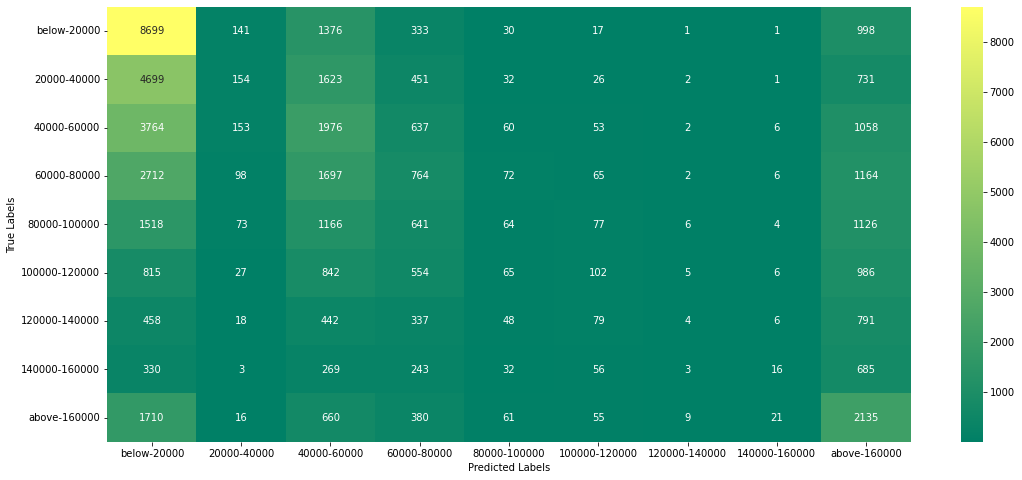

In [24]:
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, labels = labels_order), 
            annot = True, 
            xticklabels = labels_order, 
            yticklabels = labels_order, 
            cmap = 'summer', 
            fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()